# LLM + RAG para Dengue (Corpus BR) — Baselines, Métricas e Demo (Gradio)
Este notebook implementa e compara:
- **Baseline – LLM sem RAG**
- **RAG 1 – vector, chunk médio, top-k=5**
- **RAG 2 – vector, chunk menor, top-k=8**
- **RAG 3 – híbrido BM25 + vector + rerank**
- **RAG 4 – LLM side melhorado (prompt estruturado + few-shot) + híbrido + rerank**

Critérios: LangChain + Vector Store (Chroma), loader PDF, RecursiveCharacterTextSplitter, métricas **Faithfulness** e **Context Precision**, tabela/gráfico acerto/erro, demo Gradio.

In [1]:
!pip -q uninstall -y langchain langchain-core langchain-community langchain-text-splitters langchain-chroma
!pip -q install -U langchain langchain-core langchain-community langchain-text-splitters \
  chromadb pypdf sentence-transformers transformers accelerate torch gradio rank-bm25 hf_transfer huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 61.5 MB/s e

In [2]:
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
print("HF transfer habilitado")

HF transfer habilitado


In [3]:
import os, re, math, random
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.retrievers import BM25Retriever
from langchain_community.llms import HuggingFacePipeline
from langchain_core.prompts import PromptTemplate

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

def set_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("OK: imports + seed")

OK: imports + seed


## 1) Corpus BR (PDFs) + download
Preencha `PDF_URLS` com links oficiais em PDF (Ministério da Saúde/Secretarias etc.), ou faça upload de PDFs na pasta `dengue_pdfs/`.

In [4]:
import requests
from glob import glob

DATA_DIR = "dengue_pdfs"
os.makedirs(DATA_DIR, exist_ok=True)

PDF_URLS = [
    # COLE AQUI LINKS DE PDFs OFICIAIS BR
    # 1) Protocolo nacional de manejo clínico - adulto e criança (edição recente)
    "https://bvsms.saude.gov.br/bvs/publicacoes/dengue_diagnostico_manejo_clinico_6ed.pdf",

    # 2) Guia de Vigilância em Saúde - volume 3 (capítulo de dengue e outras arboviroses)
    "https://bvsms.saude.gov.br/bvs/publicacoes/guia_vigilancia_saude_6ed_v3.pdf",

    # 3) Guia prático de arboviroses urbanas na Atenção Primária à Saúde
    "https://bvsms.saude.gov.br/bvs/publicacoes/guia_pratico_arboviroses_urbanas_aps.pdf",

    # 4) Dengue: manual de enfermagem
    "https://bvsms.saude.gov.br/bvs/publicacoes/dengue_manual_enfermagem.pdf",

    # 5) O Agente Comunitário de Saúde no controle da dengue
    "https://bvsms.saude.gov.br/bvs/publicacoes/agente_comunitario_saude_controle_dengue.pdf",
]

def download_pdfs(urls, dest_dir=DATA_DIR):
    for url in urls:
        name = url.split("/")[-1] or "arquivo.pdf"
        path = os.path.join(dest_dir, name)
        if os.path.exists(path):
            print("Já existe:", path)
            continue
        print("Baixando:", url)
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        with open(path, "wb") as f:
            f.write(r.content)

if PDF_URLS:
    download_pdfs(PDF_URLS, DATA_DIR)
else:
    print("ATENÇÃO: PDF_URLS vazio. Faça upload de PDFs em dengue_pdfs/ ou preencha os links.")

print("Arquivos:", [f for f in os.listdir(DATA_DIR) if f.lower().endswith(".pdf")])

Baixando: https://bvsms.saude.gov.br/bvs/publicacoes/dengue_diagnostico_manejo_clinico_6ed.pdf
Baixando: https://bvsms.saude.gov.br/bvs/publicacoes/guia_vigilancia_saude_6ed_v3.pdf
Baixando: https://bvsms.saude.gov.br/bvs/publicacoes/guia_pratico_arboviroses_urbanas_aps.pdf
Baixando: https://bvsms.saude.gov.br/bvs/publicacoes/dengue_manual_enfermagem.pdf
Baixando: https://bvsms.saude.gov.br/bvs/publicacoes/agente_comunitario_saude_controle_dengue.pdf
Arquivos: ['guia_pratico_arboviroses_urbanas_aps.pdf', 'dengue_diagnostico_manejo_clinico_6ed.pdf', 'agente_comunitario_saude_controle_dengue.pdf', 'dengue_manual_enfermagem.pdf', 'guia_vigilancia_saude_6ed_v3.pdf']


## 2) Loader (LangChain) + checagem do mínimo (10 PDFs ou 50 páginas)

In [5]:
pdf_paths = sorted(glob(os.path.join(DATA_DIR, "*.pdf")))

all_pages = []
for p in pdf_paths:
    loader = PyPDFLoader(p)
    pages = loader.load()  # 1 Document por página
    all_pages.extend(pages)

num_pdfs = len(pdf_paths)
num_pages = len(all_pages)

print(f"PDFs: {num_pdfs} | Páginas carregadas: {num_pages}")

if not (num_pdfs >= 10 or num_pages >= 50):
    print("\n[ALERTA] Checklist: você precisa de >=10 PDFs OU >=50 páginas.")
else:
    print("\nOK: corpus atende ao mínimo.")

PDFs: 5 | Páginas carregadas: 509

OK: corpus atende ao mínimo.


## 3) Split (RecursiveCharacterTextSplitter)
Geramos chunks médios (RAG1) e pequenos (RAG2/3/4).

In [6]:
splitter_medium = RecursiveCharacterTextSplitter(
    chunk_size=1200, chunk_overlap=150, separators=["\n\n", "\n", ". ", " "]
)
splitter_small = RecursiveCharacterTextSplitter(
    chunk_size=600, chunk_overlap=100, separators=["\n\n", "\n", ". ", " "]
)

docs_medium = splitter_medium.split_documents(all_pages)
docs_small = splitter_small.split_documents(all_pages)

print("Chunks médios:", len(docs_medium))
print("Chunks pequenos:", len(docs_small))

Chunks médios: 1080
Chunks pequenos: 2030


## 4) Embeddings + Vector Store (Chroma)

In [7]:
EMBED_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
embeddings = HuggingFaceEmbeddings(model_name=EMBED_MODEL)

vstore_medium = Chroma.from_documents(docs_medium, embeddings, collection_name="dengue_medium")
vstore_small  = Chroma.from_documents(docs_small,  embeddings, collection_name="dengue_small")

print("OK: Chroma stores criados")

/tmp/ipython-input-2215328402.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=EMBED_MODEL)
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

OK: Chroma stores criados


## 5) Retrievers + híbrido + rerank (RAG3/RAG4)

In [8]:
retriever_medium = vstore_medium.as_retriever(search_kwargs={"k": 5})
retriever_small  = vstore_small.as_retriever(search_kwargs={"k": 8})

bm25 = BM25Retriever.from_documents(docs_small)
bm25.k = 8

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    a = a / (np.linalg.norm(a) + 1e-9)
    b = b / (np.linalg.norm(b) + 1e-9)
    return float(np.dot(a, b))

def embed_texts(texts: List[str]) -> np.ndarray:
    return np.array(embeddings.embed_documents(texts))

def embed_query(text: str) -> np.ndarray:
    return np.array(embeddings.embed_query(text))

def rerank_by_embedding(question: str, docs: List[Any], final_k: int = 8) -> List[Any]:
    if not docs:
        return []
    qv = embed_query(question)
    texts = [d.page_content[:1000] for d in docs]
    dvecs = embed_texts(texts)
    scores = [cosine_sim(qv, dv) for dv in dvecs]
    idx = np.argsort(scores)[::-1][:final_k]
    return [docs[i] for i in idx]

# ===== HÍBRIDO MANUAL (BM25 + Vector) =====
def hybrid_candidates(question: str, candidate_k: int = 24) -> List[Any]:
    bm25.k = candidate_k
    retriever_small.search_kwargs["k"] = candidate_k

    docs_bm25 = bm25.invoke(question) # Changed from get_relevant_documents
    docs_vec  = retriever_small.invoke(question)

    # merge + dedup
    seen = set()
    merged = []
    for d in (docs_bm25 + docs_vec):
        key = (
            d.metadata.get("source", ""),
            d.metadata.get("page", ""),
            hash((d.page_content or "")[:400])
        )
        if key not in seen:
            seen.add(key)
            merged.append(d)

    return merged

def hybrid_with_rerank(question: str, candidate_k: int = 24, final_k: int = 8) -> List[Any]:
    cand = hybrid_candidates(question, candidate_k=candidate_k)
    return rerank_by_embedding(question, cand, final_k=final_k)

print("OK: retrievers + híbrido manual + reranker")

OK: retrievers + híbrido manual + reranker


## 6) LLM open-source no Colab (sem OpenAI)
Dica: Qwen instruct costuma ser bem mais estável que TinyLlama com contexto grande.

In [9]:
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"  # se ficar pesado, troque por um menor compatível

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
)

gen = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=384,
    do_sample=False,
    temperature=0.0,
    repetition_penalty=1.10,
    return_full_text=False,
)

llm = HuggingFacePipeline(pipeline=gen)
print("OK: LLM carregado ->", MODEL_NAME)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


OK: LLM carregado -> Qwen/Qwen2.5-1.5B-Instruct


/tmp/ipython-input-2862143046.py:21: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=gen)


## 7) Configs Baseline/RAG1..RAG4 + prompts + limite de contexto

In [10]:
@dataclass
class RagConfig:
    key: str
    name: str
    use_rag: bool
    retriever_type: str   # none | vector_medium | vector_small | hybrid
    top_k: int
    prompt_style: str     # simple | structured
    few_shot: bool

CONFIGS: Dict[str, RagConfig] = {
    "baseline": RagConfig("baseline", "Baseline – LLM sem RAG", False, "none", 0, "simple", False),
    "rag1": RagConfig("rag1", "RAG 1 – vector, chunk médio, top-k=5", True, "vector_medium", 5, "simple", False),
    "rag2": RagConfig("rag2", "RAG 2 – vector, chunk menor, top-k=8", True, "vector_small", 8, "simple", False),
    "rag3": RagConfig("rag3", "RAG 3 – híbrido BM25+vector + rerank", True, "hybrid", 8, "simple", False),
    "rag4": RagConfig("rag4", "RAG 4 – LLM side melhorado (híbrido + rerank + few-shot + estruturado)", True, "hybrid", 8, "structured", True),
}

FEW_SHOT = [
    ("Quais são sintomas iniciais mais comuns da dengue?",
     "Sintomas iniciais costumam incluir febre alta, cefaleia, dor retro-orbitária, mialgia e mal-estar."),
    ("O que são sinais de alarme na dengue?",
     "Sinais de alarme indicam risco de agravamento, como dor abdominal intensa, vômitos persistentes e sangramentos."),
]

def format_few_shot(pairs):
    return "\n\n".join([f"Pergunta: {q}\nResposta: {a}" for q, a in pairs])

PROMPT_SIMPLE = PromptTemplate(
    input_variables=["question","context"],
    template=("Você é um assistente sobre dengue baseado em documentos oficiais brasileiros. "
              "Use SOMENTE o contexto para responder. Se não houver suporte no contexto, diga isso claramente.\n\n"
              "Contexto:\n{context}\n\nPergunta:\n{question}\n\nResposta:")
)

PROMPT_STRUCTURED = PromptTemplate(
    input_variables=["question","context","fewshot"],
    template=("Você é um assistente de saúde sobre dengue baseado em protocolos brasileiros. "
              "Não substitui um profissional de saúde. Use estritamente o contexto.\n\n"
              "Exemplos (few-shot):\n{fewshot}\n\n"
              "Contexto:\n{context}\n\nPergunta:\n{question}\n\n"
              "Responda no formato:\n"
              "1) Resposta direta (1 parágrafo)\n"
              "2) Pontos principais (tópicos)\n"
              "3) Quando procurar urgência (tópicos)\n"
              "4) Fonte(s) (arquivo e página)\n\nResposta:")
)

def pick_retriever(cfg: RagConfig):
    if not cfg.use_rag:
        return None
    if cfg.retriever_type == "vector_medium":
        retriever_medium.search_kwargs["k"] = cfg.top_k
        return retriever_medium
    if cfg.retriever_type == "vector_small":
        retriever_small.search_kwargs["k"] = cfg.top_k
        return retriever_small
    if cfg.retriever_type == "hybrid":
        bm25.k = cfg.top_k
        retriever_small.search_kwargs["k"] = cfg.top_k
        return hybrid
    return None

def docs_to_context(docs: List[Any], max_chars: int = 3500, per_doc_chars: int = 900) -> str:
    chunks = []
    total = 0
    for d in docs:
        src = os.path.basename(d.metadata.get("source",""))
        pg = d.metadata.get("page","")
        head = f"[{src} - página {pg}]\n"
        txt = (d.page_content or "").strip()[:per_doc_chars]
        piece = head + txt
        if total + len(piece) > max_chars:
            break
        chunks.append(piece)
        total += len(piece)
    return "\n\n".join(chunks)

def to_chat_prompt(system: str, user: str) -> str:
    if hasattr(tokenizer, "apply_chat_template"):
        messages = [{"role":"system","content":system},{"role":"user","content":user}]
        return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return f"SYSTEM:\n{system}\n\nUSER:\n{user}\n\nASSISTANT:\n"

print("OK: configs + prompts")

OK: configs + prompts


## 8) Métricas RAG: Context Precision e Faithfulness (dinâmicas)

In [11]:
def split_sentences_pt(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", (text or "").strip())
    if not text:
        return []
    parts = re.split(r"(?<=[\.\!\?])\s+", text)
    return [p.strip() for p in parts if p.strip()]

def context_precision_at_k(question: str, retrieved_docs: List[Any], base: float = 0.28) -> float:
    if not retrieved_docs:
        return float("nan")
    q = embed_query(question)
    doc_texts = [d.page_content[:900] for d in retrieved_docs]
    dvecs = embed_texts(doc_texts)
    sims = np.array([cosine_sim(q, dv) for dv in dvecs])
    thr = max(base, float(np.percentile(sims, 60)))
    rel = (sims >= thr).astype(float)
    return float(rel.mean())

def faithfulness(answer: str, retrieved_docs: List[Any], base: float = 0.30) -> float:
    sents = split_sentences_pt(answer)
    if not sents:
        return 0.0
    if not retrieved_docs:
        return float("nan")  # baseline: não se aplica
    ctx_texts = [d.page_content[:1200] for d in retrieved_docs]
    ctx_vecs = embed_texts(ctx_texts)
    supported = 0
    for sent in sents:
        sv = embed_query(sent)
        sims = np.array([cosine_sim(sv, cv) for cv in ctx_vecs])
        thr = max(base, float(np.percentile(sims, 75)))
        if sims.max() >= thr:
            supported += 1
    return supported / max(1, len(sents))

print("OK: métricas")

OK: métricas


## 9) Pipeline de resposta por configuração (com rerank no híbrido)

In [12]:
def run_query(question: str, cfg_key: str) -> Dict[str, Any]:
    cfg = CONFIGS[cfg_key]
    retrieved = []

    # 1) Retrieval
    if cfg.use_rag:
        if cfg.retriever_type == "hybrid":
            # RAG3/RAG4 (híbrido manual + rerank)
            retrieved = hybrid_with_rerank(question, candidate_k=24, final_k=cfg.top_k)
        elif cfg.retriever_type == "vector_medium":
            retriever_medium.search_kwargs["k"] = cfg.top_k
            retrieved = retriever_medium.invoke(question) # Changed from get_relevant_documents
        elif cfg.retriever_type == "vector_small":
            retriever_small.search_kwargs["k"] = cfg.top_k
            retrieved = retriever_small.invoke(question)  # Changed from get_relevant_documents

    # 2) Contexto
    context = docs_to_context(retrieved)

    # 3) Prompt
    if cfg.prompt_style == "structured":
        user_msg = PROMPT_STRUCTURED.format(
            question=question,
            context=context,
            fewshot=format_few_shot(FEW_SHOT) if cfg.few_shot else ""
        )
    else:
        user_msg = PROMPT_SIMPLE.format(question=question, context=context)

    system_msg = (
        "Você é um assistente sobre dengue baseado em documentos oficiais brasileiros. "
        "Use SOMENTE o contexto fornecido. Se não houver suporte no contexto, diga isso claramente. "
        "Não invente."
    )
    prompt = to_chat_prompt(system_msg, user_msg)

    # 4) LLM
    answer = llm.invoke(prompt)

    # 5) Métricas
    cp = context_precision_at_k(question, retrieved) if cfg.use_rag else float("nan")
    fw = faithfulness(answer, retrieved) if cfg.use_rag else float("nan")

    return {
        "cfg_key": cfg_key,
        "cfg_name": cfg.name,
        "question": question,
        "answer": answer,
        "retrieved_docs": retrieved,
        "context_precision": cp,
        "faithfulness": fw,
    }

## 10) Avaliação por itens (P/R/F1) + taxa_acerto/erro + métricas RAG

In [13]:
TEST_QUESTIONS = [
    "Quais são os sintomas iniciais mais comuns da dengue?",
    "O que são sinais de alarme na dengue?",
    "Quando um paciente com dengue deve procurar atendimento médico de urgência?",
    "Quais são as principais medidas para prevenir a dengue em casa?",
]

ITEMS_PER_QUESTION = [
    [("febre",[r"\bfebre\b",r"febre alta"]),
     ("cefaleia",[r"dor de cabe",r"\bcefalei"]),
     ("dor retro-orbitária",[r"atr[aá]s dos olhos",r"retro-orbit"]),
     ("mialgia",[r"dor muscular",r"\bmialg"]),
     ("artralgia",[r"dor nas articula",r"\bartralg"])],
    [("dor abdominal intensa",[r"dor abdominal",r"abdominal intensa",r"dor intensa.*abd"]),
     ("vômitos persistentes",[r"v[ôo]mit",r"persisten"]),
     ("sangramentos",[r"sangr",r"mucosa"]),
     ("hipotensão/choque",[r"press[aã]o baixa",r"hipoten",r"choque"]),
     ("hemoconcentração",[r"hemat[oó]crito",r"hemoconcentr"])],
    [("sinais de alarme",[r"sinais de alarme"]),
     ("procurar urgência",[r"urg[eê]ncia",r"pronto",r"emerg"]),
     ("sangramento importante",[r"sangr"]),
     ("dor abdominal intensa",[r"dor abdominal"]),
     ("piora do estado geral",[r"piora",r"agrav",r"estado geral"])],
    [("eliminar água parada",[r"\b[aá]gua parada\b",r"eliminar.*[aá]gua"]),
     ("tampar caixas d'água",[r"caixa d[’']?agua",r"tampar.*caixa"]),
     ("limpar calhas",[r"\bcalha"]),
     ("descartar recipientes",[r"recipien",r"garrafa",r"pneu",r"vaso"]),
     ("repelente/telas",[r"repelent",r"tela",r"mosquiteiro"])],
]

def detect_items(answer: str, items_spec):
    ans = (answer or "").lower()
    detected = {}
    for name, patterns in items_spec:
        detected[name] = 1 if any(re.search(p, ans) for p in patterns) else 0
    return detected

def prf1(detected: Dict[str,int]):
    tp = sum(detected.values())
    fn = len(detected) - tp
    fp = 0
    precision = tp / max(1, tp + fp)
    recall = tp / max(1, tp + fn)
    f1 = 0.0 if (precision+recall)==0 else 2*precision*recall/(precision+recall)
    return precision, recall, f1

def evaluate_config_items(cfg_key: str) -> pd.DataFrame:
    rows = []
    for i, q in enumerate(TEST_QUESTIONS):
        out = run_query(q, cfg_key)
        det = detect_items(out["answer"], ITEMS_PER_QUESTION[i])
        p, r, f1 = prf1(det)
        taxa_acerto = r
        rows.append({
            "config": cfg_key,
            "question_idx": i,
            "question": q,
            "precision_items": p,
            "recall_items": r,
            "f1_items": f1,
            "taxa_acerto": taxa_acerto,
            "taxa_erro": 1.0 - taxa_acerto,
            "faithfulness": out["faithfulness"],
            "context_precision": out["context_precision"],
        })
    return pd.DataFrame(rows)

details_items_df = pd.concat([evaluate_config_items(k) for k in ["baseline","rag1","rag2","rag3","rag4"]], ignore_index=True)
details_items_df.head()

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,config,question_idx,question,precision_items,recall_items,f1_items,taxa_acerto,taxa_erro,faithfulness,context_precision
0,baseline,0,Quais são os sintomas iniciais mais comuns da ...,1.0,0.4,0.571429,0.4,0.6,NaN,NaN
1,baseline,1,O que são sinais de alarme na dengue?,1.0,0.2,0.333333,0.2,0.8,NaN,NaN
2,baseline,2,Quando um paciente com dengue deve procurar at...,1.0,0.2,0.333333,0.2,0.8,NaN,NaN
3,baseline,3,Quais são as principais medidas para prevenir ...,1.0,0.4,0.571429,0.4,0.6,NaN,NaN
4,rag1,0,Quais são os sintomas iniciais mais comuns da ...,1.0,0.8,0.888889,0.8,0.2,0.375,0.4


## 11) Tabela resumo + gráfico acerto/erro

In [14]:
summary_df = (details_items_df
              .groupby("config", as_index=False)
              .agg(
                  taxa_acerto=("taxa_acerto","mean"),
                  taxa_erro=("taxa_erro","mean"),
                  precision_items=("precision_items","mean"),
                  recall_items=("recall_items","mean"),
                  f1_items=("f1_items","mean"),
                  faithfulness=("faithfulness","mean"),
                  context_precision=("context_precision","mean"),
              ))
summary_df["descricao"] = summary_df["config"].map(lambda x: CONFIGS[x].name)
summary_df = summary_df[["config","descricao","taxa_acerto","taxa_erro","precision_items","recall_items","f1_items","faithfulness","context_precision"]]
summary_df

,config,descricao,taxa_acerto,taxa_erro,precision_items,recall_items,f1_items,faithfulness,context_precision
0,baseline,Baseline – LLM sem RAG,0.30,0.70,1.0,0.30,0.452381,NaN,NaN
1,rag1,"RAG 1 – vector, chunk médio, top-k=5",0.55,0.45,1.0,0.55,0.695437,0.656250,0.400
2,rag2,"RAG 2 – vector, chunk menor, top-k=8",0.40,0.60,1.0,0.40,0.571429,0.928571,0.375
3,rag3,RAG 3 – híbrido BM25+vector + rerank,0.50,0.50,1.0,0.50,0.660714,0.791667,0.375
4,rag4,RAG 4 – LLM side melhorado (híbrido + rerank +...,0.65,0.35,1.0,0.65,0.774802,0.980769,0.375


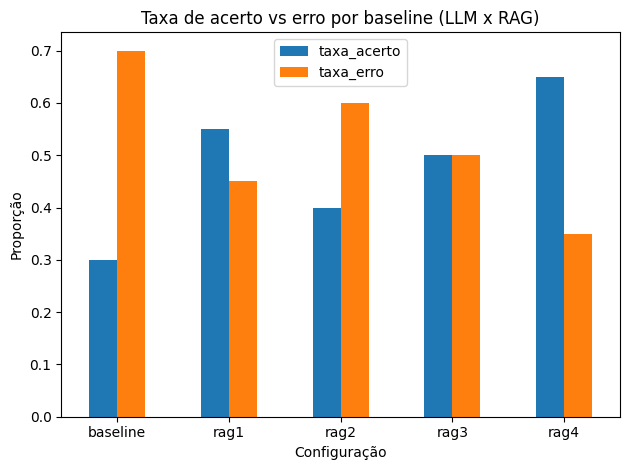

In [15]:
plot_df = summary_df.set_index("config")[["taxa_acerto","taxa_erro"]]
ax = plot_df.plot(kind="bar")
ax.set_title("Taxa de acerto vs erro por baseline (LLM x RAG)")
ax.set_ylabel("Proporção")
ax.set_xlabel("Configuração")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 12) Gradio (duas abas): Teste livre + Avaliação rápida

In [16]:
!pip -q install gradio
import gradio as gr

CONFIG_LABELS = {CONFIGS[k].name: k for k in ["baseline","rag1","rag2","rag3","rag4"]}

def format_context_for_ui(docs: List[Any], max_chars: int = 4500) -> str:
    if not docs:
        return "(Sem contexto – configuração sem RAG ou nenhum trecho recuperado.)"
    return docs_to_context(docs, max_chars=max_chars)

def fmt_metric(x):
    if x is None: return "—"
    if isinstance(x, float) and math.isnan(x): return "—"
    return f"{x:.3f}"

def ui_run_free(question: str, config_label: str, mostrar_contexto: bool):
    cfg_key = CONFIG_LABELS[config_label]
    out = run_query(question, cfg_key)
    answer = out["answer"]
    ctx = format_context_for_ui(out["retrieved_docs"]) if mostrar_contexto else "(Oculto)"
    fw, cp = out["faithfulness"], out["context_precision"]
    if (isinstance(fw,float) and math.isnan(fw)) and (isinstance(cp,float) and math.isnan(cp)):
        metrics_txt = "Métricas RAG: (não se aplica ao Baseline)"
    else:
        metrics_txt = f"Métricas RAG → Faithfulness: {fmt_metric(fw)} | Context Precision: {fmt_metric(cp)}"
    return answer, ctx, metrics_txt

def ui_run_eval(config_label: str):
    cfg_key = CONFIG_LABELS[config_label]
    df = evaluate_config_items(cfg_key)
    table = df[[
        "question_idx","question",
        "taxa_acerto","taxa_erro",
        "precision_items","recall_items","f1_items",
        "faithfulness","context_precision"
    ]].copy()
    resumo_txt = (
        f"Configuração: {CONFIGS[cfg_key].name}\n"
        f"- Taxa de acerto (média): {fmt_metric(df['taxa_acerto'].mean())}\n"
        f"- Taxa de erro (média): {fmt_metric(df['taxa_erro'].mean())}\n"
        f"- F1 médio (itens): {fmt_metric(df['f1_items'].mean())}\n"
        f"- Faithfulness médio: {fmt_metric(df['faithfulness'].mean())}\n"
        f"- Context Precision médio: {fmt_metric(df['context_precision'].mean())}\n"
    )
    return table, resumo_txt

with gr.Blocks() as demo:
    gr.Markdown("# Assistente Dengue (Baseline vs RAG)\nTeste livre e mini-avaliação.")
    with gr.Tabs():
        with gr.Tab("Teste livre"):
            question_in = gr.Textbox(label="Pergunta", lines=3, placeholder="Ex.: Quais são os sinais de alarme na dengue?")
            config_dd = gr.Dropdown(choices=list(CONFIG_LABELS.keys()), value=CONFIGS["rag4"].name, label="Configuração")
            show_ctx = gr.Checkbox(label="Mostrar contexto recuperado", value=True)
            btn = gr.Button("Gerar")
            ans_out = gr.Textbox(label="Resposta do modelo", lines=8)
            ctx_out = gr.Textbox(label="Contexto usado (RAG)", lines=10)
            met_out = gr.Textbox(label="Métricas", lines=2)
            btn.click(fn=ui_run_free, inputs=[question_in, config_dd, show_ctx], outputs=[ans_out, ctx_out, met_out])

        with gr.Tab("Avaliação rápida"):
            gr.Markdown("Roda as perguntas de TEST_QUESTIONS e gera uma tabela.")
            config_eval = gr.Dropdown(choices=list(CONFIG_LABELS.keys()), value=CONFIGS["rag4"].name, label="Configuração")
            btn_eval = gr.Button("Rodar avaliação")
            table_out = gr.Dataframe(label="Resultados por pergunta", interactive=False)
            resumo_out = gr.Textbox(label="Resumo", lines=7)
            btn_eval.click(fn=ui_run_eval, inputs=[config_eval], outputs=[table_out, resumo_out])

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://18be234c2922b218e4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
